In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import spacy
import time
from spacy.matcher import Matcher
from spacy.matcher import PhraseMatcher
from wordcloud import WordCloud
pd.set_option('display.max_rows',1000)
pd.set_option('display.max_colwidth',1000)


train_set_orig= pd.read_csv('data/train.csv')
test_set_orig = pd.read_csv('data/test.csv')

In [ ]:
print(f'Training Data has {train_set_orig.shape[0]} rows and {train_set_orig.shape[1]} columns')
print(f'Testing Data has {test_set_orig.shape[0]} rows and {train_set_orig.shape[1]} columns')

In [125]:
test_set_orig.describe()

id
count   3263.000000
mean    5427.152927
std     3146.427221
min        0.000000
25%     2683.000000
50%     5500.000000
75%     8176.000000
max    10875.000000

In [3]:
train_set_orig.head(1000)

NameError: name 'train_set_orig' is not defined

Training set has 3271 Negative tweets and 4342 Positive tweets


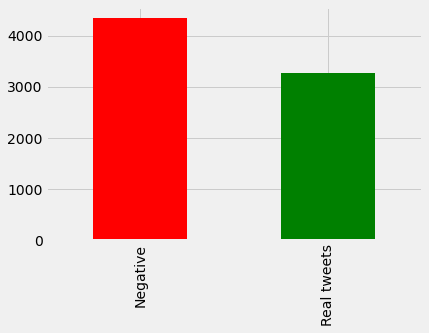

In [127]:
#number of positive and Negative tweets
PN=train_set_orig['target'].value_counts()
PN.plot(kind='bar',color=['red','green'])
plt.xticks([0,1],['Negative','Real tweets'])
print(f'Training set has {PN[1]} Negative tweets and {PN[0]} Positive tweets')

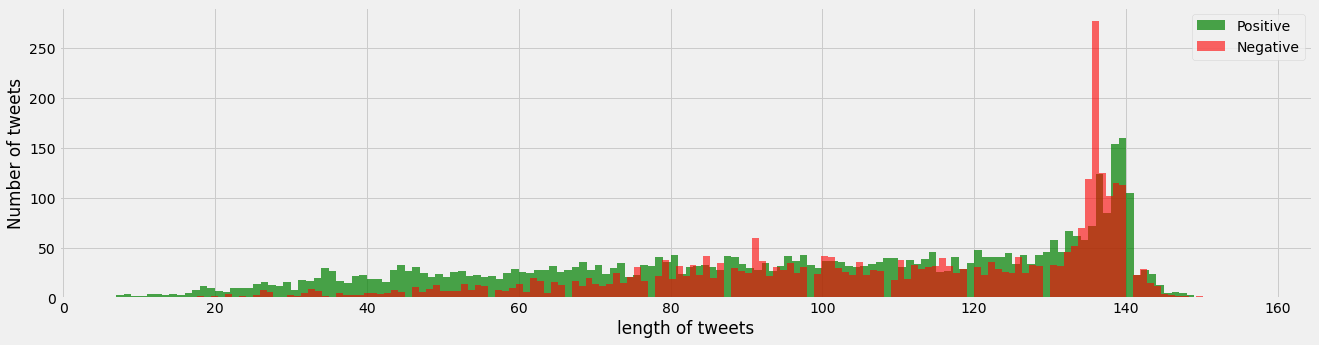

In [128]:
#Comparing length of real tweet and non real tweetss
plt.style.use('fivethirtyeight')
train_group=train_set_orig.groupby('target')
real_text_length= [len(text) for text in train_group.get_group(0)['text']]
neg_text_length= [len(text) for text in train_group.get_group(1)['text']]
bins=150
plt.figure(figsize=(20,5))
plt.hist(real_text_length,bins= bins,label='Positive',color='green',alpha= 0.7)
plt.hist(neg_text_length,bins=bins,label='Negative',color='red',alpha=0.6)
plt.xlabel('length of tweets')
plt.ylabel('Number of tweets')
plt.legend()


(0.0, 1000.0)

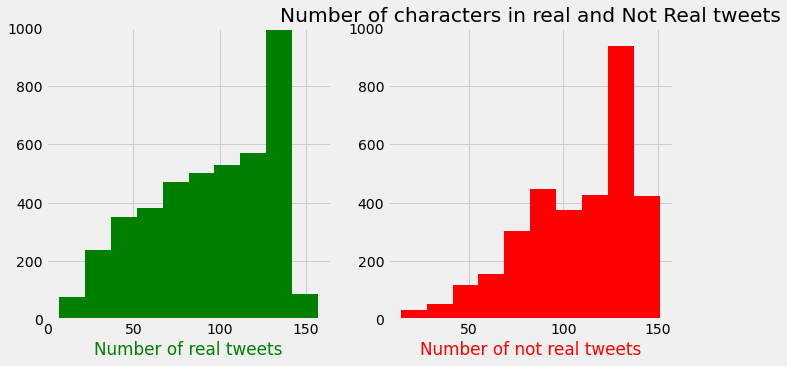

In [129]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
plt.title('Number of characters in real and Not Real tweets')
ax1.hist(real_text_length,color= 'green')
ax1.set_xlabel('Number of real tweets',color= 'green')
ax1.set_ylim([0,1000])
ax2.hist(neg_text_length,color='red')
ax2.set_xlabel('Number of not real tweets',color='red')
ax2.set_ylim([0,1000])

It can be clearly scene that tweets size between 120 to 400 length are same in both type of tweets.
But are the words length same too ??

In [130]:
def avg(x):
    return np.sum([len(word) for word in x])

neg_tweet_avg= [np.sum(list(map(avg,text)))/len(text.split()) for text in train_group.get_group(1)['text']]
post_tweet_avg= [np.sum(list(map(avg,text)))/len(text.split()) for text in train_group.get_group(0)['text']]

Text(0.5, 0, 'average tweet length')

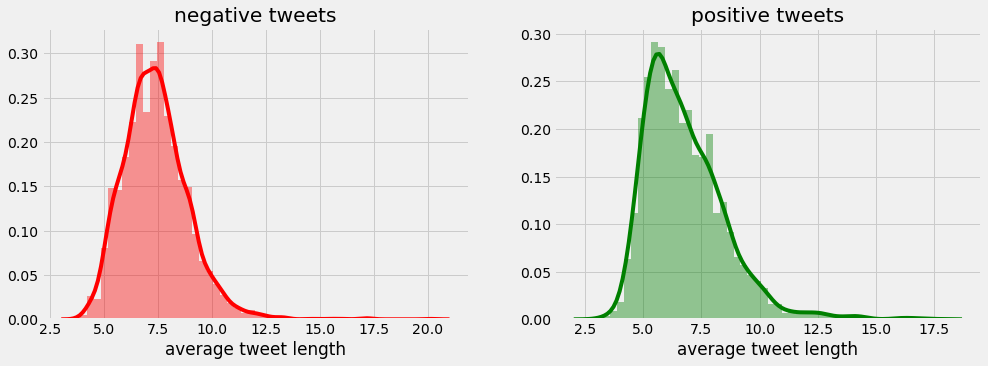

In [131]:
fig,(ax1,ax2)= plt.subplots(1,2,figsize=(15,5))
sns.distplot(neg_tweet_avg,color='red',ax=ax1)
ax1.set_title('negative tweets')
ax1.set_xlabel('average tweet length')
sns.distplot(post_tweet_avg,color='green',ax=ax2)
ax2.set_title('positive tweets')
ax2.set_xlabel('average tweet length')


In [132]:
nlp= spacy.load('en_core_web_lg')
stopwords= nlp.Defaults.stop_words

In [133]:
# import time
# tic=time.time()
# corpus=[nlp(text) for text in train_group.get_group(1)['text']]
# toc= time.time()
# print(f'time taken by using list comprehension:{(toc-tic)*1000}ms')

## time taken by using list comprehension:41624.28307533264ms


In [134]:
tic= time.time()
pos_text= train_group.get_group(0)['text'].to_string().replace('\n',' ')
neg_text= train_group.get_group(1)['text'].to_string().replace('\n',' ')

pos_corpus=nlp(pos_text)
neg_corpus=nlp(neg_text)

toc=time.time()

print(f'string conversion takes:{(toc-tic)*100}ms')
##string conversion takes:1640.8559560775757ms

matcher= PhraseMatcher(nlp.vocab)
pattern= [nlp(word) for word in stopwords]
matcher.add('stopwords',None,*pattern)

pos_matches= matcher(pos_corpus)
neg_matches= matcher(neg_corpus)

pos_words_found= [str(pos_corpus[pos_matches[i][1]:pos_matches[i][2]]) for i in range( len(pos_matches))]
neg_words_found= [str(neg_corpus[neg_matches[i][1]:neg_matches[i][2]]) for i in range( len(neg_matches))]


string conversion takes:2629.5249223709106ms


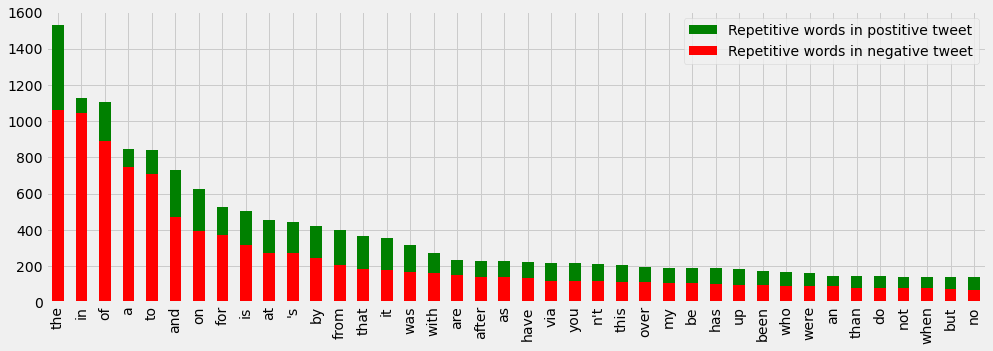

In [135]:
plt.figure(figsize=(15,5))
pd.Series(pos_words_found).value_counts()[:40].plot(kind='bar',color='green',label='Repetitive words in postitive tweet')
pd.Series(neg_words_found).value_counts()[:40].plot(kind='bar',color='red',label='Repetitive words in negative tweet')

plt.legend()


In Both positive and Negative tweet **['The' , 'a' , 'to' , 'of' , 'you']** dominates

In [136]:
pos_special_char= train_group.get_group(1)['text'].str.findall('[^A-Za-z0-9\s]')
neg_special_char= train_group.get_group(0)['text'].str.findall('[^A-Za-z0-9\s]')

/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0, flags=flags)


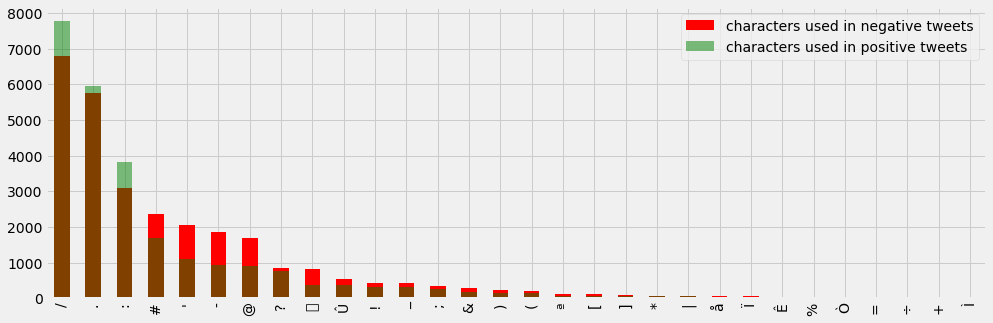

In [137]:
fig= plt.figure(figsize=(15,5))

all_neg_char=[ch for char in neg_special_char for ch in char]
pd.Series(all_neg_char).value_counts()[:30].plot(kind='bar',label='characters used in negative tweets',color='red')

all_pos_char=[ch for char in pos_special_char for ch in char]
pd.Series(all_pos_char).value_counts()[:30].plot(kind='bar',label='characters used in positive tweets',color='green',alpha=0.5)

plt.legend()


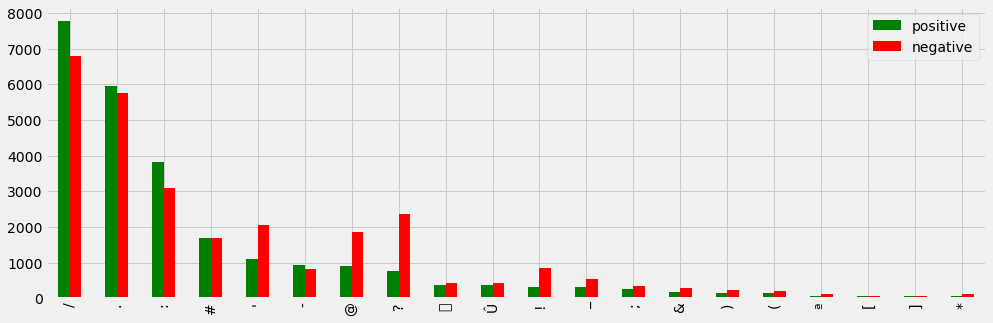

In [138]:
#Plotting more clearly using a DataFrame
n=pd.Series(all_neg_char).value_counts()
p= pd.Series(all_pos_char).value_counts()
df=pd.DataFrame({'positive':p,'negative':n}).sort_values('positive',ascending=False)[:20]
df.plot(kind='bar',figsize=(15,5),color=['green','red'])

## it will be interesting to see these figures after removing stop words

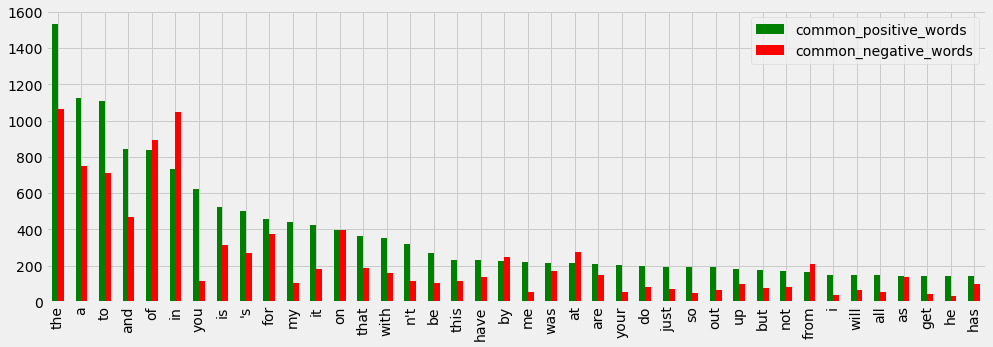

In [139]:
a=pd.Series(pos_words_found).value_counts()
b=pd.Series(neg_words_found).value_counts()
df= pd.DataFrame({'common_positive_words':a,'common_negative_words':b}).sort_values('common_positive_words',ascending=False)
df[:40].plot(kind='bar',figsize=(15,5),color=['green','red'])


## most common #HashTags in negative tweets

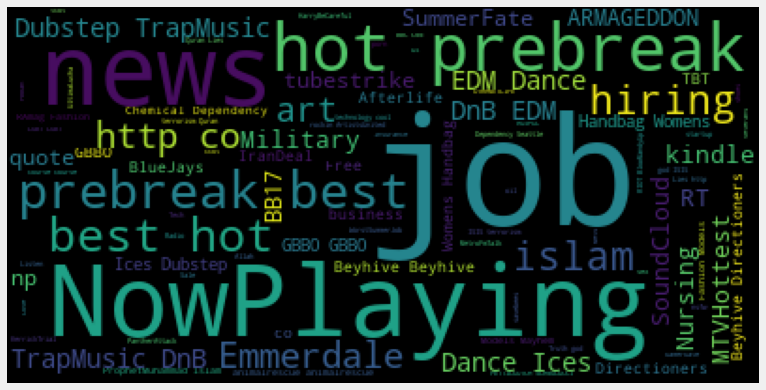

In [140]:
import re
matcher= Matcher(nlp.vocab)
pattern= [{'TEXT':{'REGEX':'#'}},{'TEXT':{'REGEX':'\w+'}}]
matcher.add('p1',None,pattern)

doc= pos_corpus
matches= matcher(doc)
hash_tags=[]
aa=[hash_tags.append(re.sub(r'_|\\n','',str(doc[matches[i][1]:matches[i][2]]))) for i in range(len(matches))]
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 80
                         ).generate(' '.join(hash_tags))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

## most common #HashTags in negative tweets

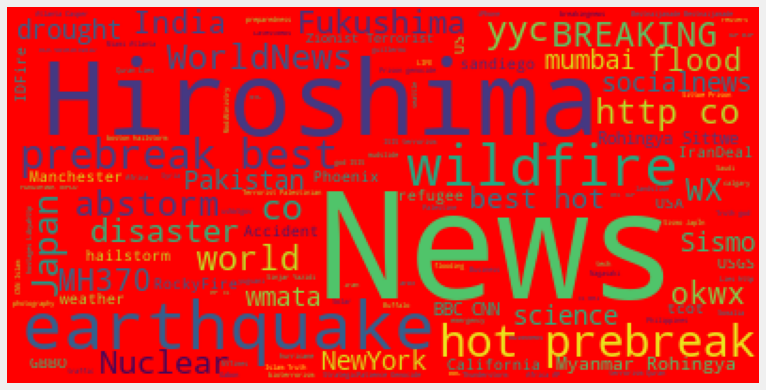

In [141]:
doc= neg_corpus
matches= matcher(doc)
hash_tags=[]
aa=[hash_tags.append(re.sub(r'_|\\n','',str(doc[matches[i][1]:matches[i][2]]))) for i in range(len(matches))]
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='red',
                          max_font_size = 80
                         ).generate(' '.join(hash_tags))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

## Data Cleaning


In [142]:
from collections import defaultdict

train= train_set_orig.copy()
test= test_set_orig.copy()

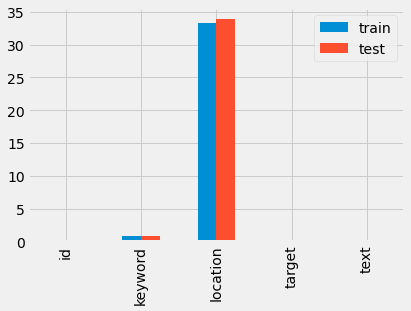

In [143]:
pd.DataFrame({'train':train.isna().sum()/len(train)*100,'test':test.isna().sum()/len(test)*100}).plot(kind='bar')

## Location column are user generated so being that much dirty and lots of empty values, it can't be used as a feature

In [144]:
train['keyword'].value_counts()[:50]

fatalities     45
deluge         42
armageddon     42
sinking        41
body%20bags    41
damage         41
harm           41
fear           40
siren          40
collided       40
twister        40
evacuate       40
windstorm      40
outbreak       40
whirlwind      39
derailment     39
collision      39
hellfire       39
sunk           39
famine         39
weapon         39
explosion      39
wrecked        39
sinkhole       39
earthquake     39
wreckage       39
weapons        39
flames         39
explode        38
ambulance      38
fatal          38
injury         38
thunder        38
bombed         38
oil%20spill    38
upheaval       38
flooding       38
hurricane      38
drowned        38
blaze          38
fire           38
deaths         38
typhoon        38
derailed       38
wreck          37
blizzard       37
emergency      37
quarantined    37
pandemonium    37
curfew         37
Name: keyword, dtype: int64

## Some values in keyword section can only be written in one context

In [145]:
train.head()

id keyword location  \
0   1     NaN      NaN   
1   4     NaN      NaN   
2   5     NaN      NaN   
3   6     NaN      NaN   
4   7     NaN      NaN   

                                                                                                                                    text  \
0                                                                  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all   
1                                                                                                 Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected   
3                                                                      13,000 people receive #wildfires evacuation orders in California    
4                                               Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school    

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [146]:
d= defaultdict(int)

unique_keywords= train['keyword'].dropna().unique()

key_group= train[['keyword','target']].groupby('keyword')
for word in unique_keywords:
    d[word]= [v for v in key_group.get_group(word)['target'].value_counts().values]


In [147]:
for word in unique_keywords:
    z= key_group.get_group(word)['target'].value_counts()
    print(f'{word} keyword has {z[0]} postive tweets and {z[1]} negative tweets')
    break

ablaze keyword has 23 postive tweets and 13 negative tweets


In [148]:
df=pd.DataFrame(d.items())
df2= pd.DataFrame(df[1].to_list(),columns=['positive','negative'])
df2.index= df[0]

df2=df2.sort_values(by='positive',ascending=False)

Text(0, 0.5, 'negative')

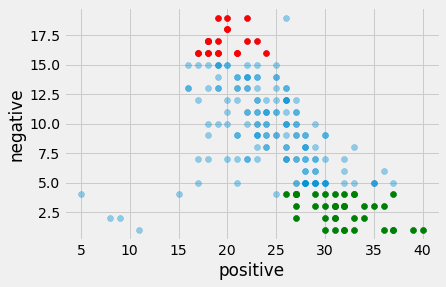

In [149]:
import matplotlib.pyplot as plt

df2=df2.sort_values(by='positive',ascending=False)
fig,ax= plt.subplots()
ax.scatter(x='positive',y='negative',data= df2,alpha=0.4)

# ax.scatter(x='positive',y='negative',data= pos,color='green')
# ax.scatter(x='positive',y='negative',data= neg,color='red')

pos_keyword=pd.DataFrame([df2.iloc[i] for i in range(len(df2)) if df2['negative'][i]<5.0 and df2['positive'][i]>25])
ax.scatter(x='positive',y='negative',data= pos_keyword,color='green')


neg_keyword= pd.DataFrame([df2.iloc[i] for i in range(len(df2)) if df2['positive'][i]<25.0 and df2['negative'][i]>15.0])
ax.scatter(x='positive',y='negative',data= neg_keyword,color='red')

# # ax.annotate('ablaze',(23,13))

plt.xlabel('positive')
plt.ylabel('negative')

 ## List of keyword which are highly positive
> pos_keyword.index
1. > ['body%20bags', 'outbreak', 'typhoon', 'oil%20spill', 'harm', 'ruin',
       'wrecked', 'explode', 'panic', 'screaming', 'traumatised', 'blazing',
       'blizzard', 'crush', 'evacuated', 'rescuers', 'suicide%20bomb',
       'bloody', 'body%20bag', 'suicide%20bombing', 'panicking', 'smoke',
       'nuclear%20disaster', 'collide', 'razed', 'electrocute', 'blew%20up',
       'blight', 'suicide%20bomber', 'stretcher', 'screamed', 'drown',
       'wildfire', 'wild%20fires', 'obliterate', 'crushed', 'mayhem',
       'bombing', 'obliterated', 'avalanche'],
      
 ## List of keyword which are highly Negative
> neg_keyword.index
 2. >['windstorm', 'collided', 'weapons', 'damage', 'burning%20buildings',
       'police', 'hurricane', 'ambulance', 'explosion', 'bombed', 'hijacker',
       'tornado', 'engulfed', 'hail', 'derail', 'rainstorm',
       'natural%20disaster', 'rescued', 'storm', 'hijack', 'lightning']

## Data Cleaning

## As the name suggest we are removing URL's

In [150]:
import re

example="New competition launched :https://www.kaggle.com/c/nlp-getting-started"
def clean_url(text):
    return re.sub(r':?http[s]?:\S+','',text)
clean_url(example)

'New competition launched '

In [151]:
train['text']= train['text'].apply(lambda x: clean_url(x))
test['text']= test['text'].apply(lambda x:clean_url(x))


## Clean Text if their is any Html tags out in our text

In [152]:
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

def clean_tag(text):
    return re.sub(r'<.*?>','',text)
print(clean_tag(example))


Real or Fake
Kaggle 
getting started



In [153]:
train['text']= train['text'].apply(lambda x:clean_tag(x))
test['text']= test['text'].apply(lambda x:clean_tag(x))


In [154]:
train.head(200)

id              keyword                       location  \
0      1                  NaN                            NaN   
1      4                  NaN                            NaN   
2      5                  NaN                            NaN   
3      6                  NaN                            NaN   
4      7                  NaN                            NaN   
5      8                  NaN                            NaN   
6     10                  NaN                            NaN   
7     13                  NaN                            NaN   
8     14                  NaN                            NaN   
9     15                  NaN                            NaN   
10    16                  NaN                            NaN   
11    17                  NaN                            NaN   
12    18                  NaN                            NaN   
13    19                  NaN                            NaN   
14    20                  NaN                            NaN   
15    23                  NaN                            NaN   
16    24                  NaN                            NaN   
17    25                  NaN                            NaN   
18    26                  NaN                            NaN   
19    28                  NaN                            NaN   
20    31                  NaN                            NaN   
21    32                  NaN                            NaN   
22    33                  NaN                            NaN   
23    34                  NaN                            NaN   
24    36                  NaN                            NaN   
25    37                  NaN                            NaN   
26    38                  NaN                            NaN   
27    39                  NaN                            NaN   
28    40                  NaN                            NaN   
29    41                  NaN                            NaN   
30    44                  NaN                            NaN   
31    48               ablaze                     Birmingham   
32    49               ablaze  Est. September 2012 - Bristol   
33    50               ablaze                         AFRICA   
34    52               ablaze               Philadelphia, PA   
35    53               ablaze                     London, UK   
36    54               ablaze                       Pretoria   
37    55               ablaze                   World Wide!!   
38    56               ablaze                            NaN   
39    57               ablaze                 Paranaque City   
40    59               ablaze                 Live On Webcam   
41    61               ablaze                            NaN   
42    62               ablaze                      milky way   
43    63               ablaze                            NaN   
44    64               ablaze                            NaN   
45    65               ablaze                            NaN   
46    66               ablaze      GREENSBORO,NORTH CAROLINA   
47    67               ablaze                            NaN   
48    68               ablaze                 Live On Webcam   
49    71               ablaze                       England.   
50    73               ablaze       Sheffield Township, Ohio   
51    74               ablaze                          India   
52    76               ablaze                       Barbados   
53    77               ablaze                        Anaheim   
54    78               ablaze                          Abuja   
55    79               ablaze                            USA   
56    80               ablaze                   South Africa   
57    81               ablaze              Sao Paulo, Brazil   
58    82               ablaze                 hollywoodland    
59    83               ablaze   Edmonton, Alberta - Treaty 6   
60    85               ablaze                            NaN   
61    86               ablaze         

## Remove Symbols, and make every text in lower format but keep @ and # because they signify the @User and #Topic

In [155]:
def non_alpha(text):
    return re.sub('[^A-Za-z0-9\'@#]+',' ',text).lower()
print(non_alpha("ÛÏ@LeoBlakeCarter: This #dog thinks he's an am."))

 @leoblakecarter this #dog thinks he's an am 


In [156]:
train['text']= train['text'].apply(lambda x: non_alpha(x))
test['text']= test['text'].apply(lambda x:non_alpha(x))


In [157]:
train.head(400)

id              keyword                       location  \
0      1                  NaN                            NaN   
1      4                  NaN                            NaN   
2      5                  NaN                            NaN   
3      6                  NaN                            NaN   
4      7                  NaN                            NaN   
5      8                  NaN                            NaN   
6     10                  NaN                            NaN   
7     13                  NaN                            NaN   
8     14                  NaN                            NaN   
9     15                  NaN                            NaN   
10    16                  NaN                            NaN   
11    17                  NaN                            NaN   
12    18                  NaN                            NaN   
13    19                  NaN                            NaN   
14    20                  NaN                            NaN   
15    23                  NaN                            NaN   
16    24                  NaN                            NaN   
17    25                  NaN                            NaN   
18    26                  NaN                            NaN   
19    28                  NaN                            NaN   
20    31                  NaN                            NaN   
21    32                  NaN                            NaN   
22    33                  NaN                            NaN   
23    34                  NaN                            NaN   
24    36                  NaN                            NaN   
25    37                  NaN                            NaN   
26    38                  NaN                            NaN   
27    39                  NaN                            NaN   
28    40                  NaN                            NaN   
29    41                  NaN                            NaN   
30    44                  NaN                            NaN   
31    48               ablaze                     Birmingham   
32    49               ablaze  Est. September 2012 - Bristol   
33    50               ablaze                         AFRICA   
34    52               ablaze               Philadelphia, PA   
35    53               ablaze                     London, UK   
36    54               ablaze                       Pretoria   
37    55               ablaze                   World Wide!!   
38    56               ablaze                            NaN   
39    57               ablaze                 Paranaque City   
40    59               ablaze                 Live On Webcam   
41    61               ablaze                            NaN   
42    62               ablaze                      milky way   
43    63               ablaze                            NaN   
44    64               ablaze                            NaN   
45    65               ablaze                            NaN   
46    66               ablaze      GREENSBORO,NORTH CAROLINA   
47    67               ablaze                            NaN   
48    68               ablaze                 Live On Webcam   
49    71               ablaze                       England.   
50    73               ablaze       Sheffield Township, Ohio   
51    74               ablaze                          India   
52    76               ablaze                       Barbados   
53    77               ablaze                        Anaheim   
54    78               ablaze                          Abuja   
55    79               ablaze                            USA   
56    80               ablaze                   South Africa   
57    81               ablaze              Sao Paulo, Brazil   
58    82               ablaze                 hollywoodland    
59    83               ablaze   Edmonton, Alberta - Treaty 6   
60    85               ablaze                            NaN   
61    86               ablaze         

## Removing @User name

In [158]:
example='@Mohit1 @ Mohit2 @m @moo mohit5t01c @mohit5t01c hello Mohit @phdsquares'
def remove_user(text):
    text= re.sub(r'(@[A-Za-z0-9]?[A-Za-z0-9]*)| \s[A-Za-z0-9]+\s','',text).split()
    print(text)
    text=[word for word in text if word.isalpha() == True and len(word)>2]
    print(text)
    text= ' '.join(text)
    return text
remove_user(example)

['Mohit2', 'mohit5t01c', 'hello', 'Mohit']
['hello', 'Mohit']


'hello Mohit'

In [159]:
train['text']= train['text'].apply(lambda x:remove_user(x))
test['text']= test['text'].apply(lambda x:remove_user(x))


['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', '#earthquake', 'may', 'allah', 'forgive', 'us', 'all']
['our', 'deeds', 'are', 'the', 'reason', 'this', 'may', 'allah', 'forgive', 'all']
['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada']
['forest', 'fire', 'near', 'ronge', 'sask', 'canada']
['all', 'residents', 'asked', 'to', "'shelter", 'in', "place'", 'are', 'being', 'notified', 'by', 'officers', 'no', 'other', 'evacuation', 'or', 'shelter', 'in', 'place', 'orders', 'are', 'expected']
['all', 'residents', 'asked', 'are', 'being', 'notified', 'officers', 'other', 'evacuation', 'shelter', 'place', 'orders', 'are', 'expected']
['13', '000', 'people', 'receive', '#wildfires', 'evacuation', 'orders', 'in', 'california']
['people', 'receive', 'evacuation', 'orders', 'california']
['just', 'got', 'sent', 'this', 'photo', 'from', 'ruby', '#alaska', 'as', 'smoke', 'from', '#wildfires', 'pours', 'into', 'a', 'school']
['just', 'got', 'sent', 'this', 'photo', 'from', 'ruby', 'smo

['was', 'going', 'tell', 'him', 'but', 'you', 'were', 'body', 'bagging', 'him']
['leo', 'no', 'caption', 'needed', 'freshman', 'nigga', 'stacey', 'body', 'bagging', 'niggas']
['leo', 'caption', 'needed', 'freshman', 'nigga', 'stacey', 'body', 'bagging', 'niggas']
['aubrey', 'really', 'out', 'here', 'body', 'bagging', 'meek']
['aubrey', 'really', 'out', 'here', 'body', 'bagging', 'meek']
['8', 'hours', 'of', 'bagging', 'groceries', 'an', 'aching', 'body']
['hours', 'bagging', 'groceries', 'aching', 'body']
['drake', 'really', 'body', 'bagging', 'peeps', 'man', 'he', 'really', 'bout', 'it']
['drake', 'really', 'body', 'bagging', 'peeps', 'man', 'really', 'bout']
['when', 'you', 'call', 'to', 'report', 'dangerous', 'activity', 'tell', 'em', 'to', 'have', 'body', 'bags', 'on', 'arrival']
['when', 'you', 'call', 'report', 'dangerous', 'activity', 'tell', 'have', 'body', 'bags', 'arrival']
['micom', '2015', 'summer', 'contrast', 'candy', 'color', 'bowknot', 'cross', 'body', 'tote', 'shoulder

['storm', 'worse', 'than', 'last', 'hurricane', 'city', 'amp', 'hardest', 'hit', 'yard', 'looks', 'like', 'was', 'bombed', 'around', 'still', 'without', 'power']
['a', 'wasp', 'just', 'dive', 'bombed', 'my', 'face']
['wasp', 'just', 'dive', 'bombed', 'face']
['misfit', 'got', 'bombed']
['misfit', 'got', 'bombed']
['the', 'united', 'kingdom', 'and', 'france', 'are', 'bombing', 'daesh', 'in', 'syria', 'voltaire', 'network']
['the', 'united', 'kingdom', 'and', 'france', 'are', 'bombing', 'daesh', 'syria', 'voltaire', 'network']
["it's", 'been', '70', 'years', 'and', 'one', 'hour', 'since', 'the', 'bombing', 'of', 'hiroshima', "let's", 'take', 'this', 'time', 'to', 'remember']
['been', 'years', 'and', 'one', 'hour', 'since', 'the', 'bombing', 'hiroshima', 'take', 'this', 'time', 'remember']
['the', 'cryptic', 'words', 'that', 'guided', 'pilots', 'on', 'the', 'hiroshima', 'bombing', 'mission']
['the', 'cryptic', 'words', 'that', 'guided', 'pilots', 'the', 'hiroshima', 'bombing', 'mission']


['awwww', 'baby', 'walter']
["'the", 'big', 'ten', 'has', 'their', 'annual', 'football', 'media', 'day', 'but', 'before', 'we', 'get', 'into', 'that', "here's", 'some', 'cyclone', 'hoops', 'recruiting', "nuggets'"]
['big', 'ten', 'has', 'their', 'annual', 'football', 'media', 'day', 'but', 'before', 'get', 'into', 'that', 'some', 'cyclone', 'hoops', 'recruiting']
['#camera', '#art', '#photography', '#0215', 'new', 'bolt', 'cyclone', 'dr', 'pp', '400dr', 'dual', 'outlet', 'power', 'pack', 'for', 'external', 'camera', 'flash', '30']
['new', 'bolt', 'cyclone', 'dual', 'outlet', 'power', 'pack', 'for', 'external', 'camera', 'flash']
['it', 'works', 'for', 'my', 'purpose', 'a', 'large', 'cyclone', 'would', 'be', 'better', 'i', 'just', "don't", 'have', '4k', 'this', 'was', '500']
['works', 'for', 'purpose', 'large', 'cyclone', 'would', 'better', 'just', 'have', 'this', 'was']
['a', 'new', 'tropical', 'cyclone', 'is', 'forming', 'near', 'guam', 'once', 'it', 'is', 'formed', 'it', 'will', 'be'

['just', 'watched', 'emmerdale', 'know', 'who', 'most', 'them', 'are', 'but', 'slightly', 'attractive', 'man', 'named', 'ross', 'just', 'got', 'beat', 'now', 'dead']
['i', 'need', 'you', 'to', 'confirm', 'that', 'ross', 'is', 'dead', 'cause', 'i', 'dont', 'trust', 'anyone', 'else', 'yh']
['need', 'you', 'confirm', 'that', 'ross', 'dead', 'cause', 'dont', 'trust', 'anyone', 'else']
['#iwasdisappointedby', "telltale's", 'the', 'walking', 'dead', 'good', 'characters', 'amp', 'story', 'but', 'no', 'real', 'gameplay', 'and', 'too', 'many', 'performance', 'issues']
['the', 'walking', 'dead', 'good', 'characters', 'amp', 'story', 'but', 'real', 'gameplay', 'and', 'too', 'many', 'performance', 'issues']
['beforeitsnews', 'hundreds', 'feared', 'dead', 'after', 'libyan', 'migrant', 'boat', 'capsizes', 'during', 'rescue']
['beforeitsnews', 'hundreds', 'feared', 'dead', 'after', 'libyan', 'migrant', 'boat', 'capsizes', 'during', 'rescue']
['if', 'it', 's', 'a', 'war', 'you', 'came', 'to', 'see', '

['only', 'urs', 'and', 'srs', 'matter', 'drowning', 'tho', 'already', 'drowning', 'lol']
['i', 'feel', 'like', "i'm", 'drowning', 'inside', 'my', 'own', 'body']
['feel', 'like', 'drowning', 'inside', 'own', 'body']
["i'm", 'drowning', 'in', 'hw', 'now', 'and', "that's", 'w', 'o', 'going', 'to', 'swim', 'ohlordy']
['drowning', 'now', 'and', 'going', 'swim', 'ohlordy']
['bg', '16', 'so', 'far', 'brunt', 'of', 'storm', 'just', 'to', 'our', 'north', 'grayed', 'out', 'w', 'dust', 'amp', 'rain', 'to', 'n', 'blue', 'sky', 'interspersed', 'w', 'clouds', 'to', 's']
['far', 'brunt', 'storm', 'just', 'our', 'north', 'grayed', 'out', 'dust', 'amp', 'rain', 'blue', 'sky', 'interspersed', 'clouds']
['some', 'poor', 'sods', 'arriving', 'in', 'amman', 'during', "yesterday's", 'dust', 'storm', 'were', 'diverted', 'to', 'ben', 'gurion', 'airport']
['some', 'poor', 'sods', 'arriving', 'amman', 'during', 'dust', 'storm', 'were', 'diverted', 'ben', 'gurion', 'airport']
['kids', 'disappear', 'in', 'dust', '

['floods', 'fishing', 'finally', 'sunshine', 'amp', 'fab', 'deals', 'from', 'albertsons', 'anniversary', 'sale', 'lauren', 'paints', 'beautiful', 'life']
['#flood', '#disaster', 'bengal', 'floods', 'cm', 'mamata', 'banerjee', 'blames', 'dvc', 'bjp', 'claims', 'state', 'failed', 'to', 'use', 'economic', 't']
['bengal', 'floods', 'mamata', 'banerjee', 'blames', 'dvc', 'bjp', 'claims', 'state', 'failed', 'use', 'economic']
['69', 'dead', 'due', 'to', 'floods', 'in', 'myanmar', 'naypyidaw', 'aug', '5', 'prensa', 'latina', 'the', 'death', 'toll', 'rose', 'today', 'to', '69', 'in', 'myanmar']
['dead', 'due', 'floods', 'myanmar', 'naypyidaw', 'aug', 'prensa', 'latina', 'the', 'death', 'toll', 'rose', 'today', 'myanmar']
['typhoon', 'soudelor', 'approaches', 'after', '7', 'killed', '2', 'missing', 'in', 'floods', 'in', 'philippines', 'via']
['typhoon', 'soudelor', 'approaches', 'after', 'killed', 'missing', 'floods', 'philippines', 'via']
['when', 'it', 'rains', 'in', 'nj', 'it', 'flash', 'flo

['obliterate', 'you', 'the', 'shadow', 'realm']
['gop', 'debate', 'tonight', 'but', 'no', 'jon', 'stewart', 'next', 'week', 'to', 'obliterate', 'them', '#jonvoyage']
['gop', 'debate', 'tonight', 'but', 'jon', 'stewart', 'next', 'week', 'obliterate', 'them']
['think', 'how', 'spectacular', 'it', 'will', 'look', 'when', 'the', 'stonewall', 'riots', 'obliterate', 'the', 'white', 'house']
['think', 'how', 'spectacular', 'will', 'look', 'when', 'the', 'stonewall', 'riots', 'obliterate', 'the', 'white', 'house']
['watch', 'sarah', 'palin', 'obliterate', 'planned', 'parenthood', 'for', 'targeting', 'minority', 'women', 'bb4sp']
['watch', 'sarah', 'palin', 'obliterate', 'planned', 'parenthood', 'for', 'targeting', 'minority', 'women']
['how', 'is', 'this', 'scum', 'still', 'alive', 'obliterate', 'this', 'cancer']
['how', 'this', 'scum', 'still', 'alive', 'obliterate', 'this', 'cancer']
['wwe', '2k15', 'universe', 'mode', 'part', '149', 'obliterate', 'via']
['wwe', 'universe', 'mode', 'part', '

['i', 'was', 'obliterated', 'last', 'night']
['was', 'obliterated', 'last', 'night']
['wackos', 'like', '#michelebachman', 'predict', 'the', 'world', 'will', 'soon', 'be', 'obliterated', 'by', 'a', 'burning', 'firey', 'inferno', 'but', 'cant', 'accept', '#globalwarming', 'hello']
['wackos', 'like', 'predict', 'the', 'world', 'will', 'soon', 'obliterated', 'burning', 'firey', 'inferno', 'but', 'cant', 'accept', 'hello']
['drunk', 'meals', '101', 'what', 'to', 'cook', 'when', "you're", 'totally', 'obliterated']
['drunk', 'meals', 'what', 'cook', 'when', 'totally', 'obliterated']
['uribe', 'just', 'obliterated', 'a', 'baseball']
['uribe', 'just', 'obliterated', 'baseball']
['shtap', 'before', 'your', 'town', 'is', 'obliterated', 'and', 'the', 'earth', 'is', 'salted', 't', 't']
['shtap', 'before', 'your', 'town', 'obliterated', 'and', 'the', 'earth', 'salted']
['i', "can't", 'wait', 'to', 'be', 'beyond', 'obliterated', 'this', 'weekend']
['wait', 'beyond', 'obliterated', 'this', 'weekend']

['been', 'trying', 'write', 'theological', 'short', 'story', 'about', 'monster', 'living', 'sinkhole', 'then', 'heard', 'about', 'brooklyn']
['sinkhole', 'selfies', 'you', 'wont', 'believe', "what's", 'in', 'the', 'brooklyn', 'sinkhole']
['sinkhole', 'selfies', 'you', 'wont', 'believe', 'the', 'brooklyn', 'sinkhole']
['loads', 'of', 'stuff', 'going', 'on', 'recently', 'see', 'the', 'blog', 'at', '#sinkhole', '#piling']
['loads', 'stuff', 'going', 'recently', 'see', 'the', 'blog']
['150', 'foot', 'sinkhole', 'opens', 'in', 'lowndes', 'county', 'residential', 'area']
['foot', 'sinkhole', 'opens', 'lowndes', 'county', 'residential', 'area']
['#sandiego', '#news', 'sinkhole', 'disrupts', 'downtown', 'trolley', 'service', 'the', 'incident', 'happened', 'wed', '#algeria', '#']
['sinkhole', 'disrupts', 'downtown', 'trolley', 'service', 'the', 'incident', 'happened', 'wed']
['beforeitsnews', 'a', 'sinkhole', 'grows', 'in', 'brooklyn', 'six', 'meter', 'crater', 'swallows', 'street']
['beforeits

['smoke', 'whatever', 'you', 'got']
['smoke', 'the', 'weed', 'snoop', 'lion', 'ft', 'collie', 'buddz']
['smoke', 'the', 'weed', 'snoop', 'lion', 'collie', 'buddz']
['and', 'all', 'you', 'girls', 'that', 'smoke', 'have', 'you', 'notice', 'that', 'you', 'started', 'to', 'lose', 'alot', 'of', 'weight', 'hmmm', "don't", 'know', 'body', 'want', 'no', 'thin', 'girl', 'tf']
['and', 'all', 'you', 'girls', 'that', 'smoke', 'have', 'you', 'notice', 'that', 'you', 'started', 'lose', 'alot', 'weight', 'hmmm', 'know', 'body', 'want', 'thin', 'girl']
['smoke', 'with', 'me', 'baby', 'and', 'lay', 'with', 'me', 'baby', 'and', 'laugh', 'with', 'me', 'baby', 'i', 'just', 'want', 'the', 'simple', 'things']
['smoke', 'with', 'baby', 'and', 'lay', 'with', 'baby', 'and', 'laugh', 'with', 'baby', 'just', 'want', 'the', 'simple', 'things']
['im', 'gonna', 'get', 'naked', 'and', 'smoke', 'my', 'cigarette', 'someone', 'call', 'me', 'radneck', 'or', 'is', 'it', 'just', 'too', 'hot', 'in', 'here']
['gonna', 'get'

['950', 'if', 'a', 'landslide', 'tumbles', 'down', "todayi'm", 'on', 'your', 'side', 'and', 'if', 'a', 'twister', 'sweeps', 'it', 'all', 'away', "you're", 'on', 'your', 'own', 'bitch', 'runs', 'into', 'distance']
['landslide', 'tumbles', 'down', 'your', 'side', 'and', 'twister', 'sweeps', 'all', 'away', 'your', 'own', 'bitch', 'runs', 'into', 'distance']
['love', '106', '1', 'the', 'twister', 'and', 'maddie', 'and', 'tae', '#oktxduo']
['love', 'the', 'twister', 'and', 'maddie', 'and', 'tae']
['brain', 'twister', 'homefolks', 'are', 'opinionated', 'over', 'against', 'proposal', 'modernized', 'canada', 'omw']
['brain', 'twister', 'homefolks', 'are', 'opinionated', 'over', 'against', 'proposal', 'modernized', 'canada', 'omw']
['crazy', 'mom', 'threw', 'teen', 'daughter', 'a', 'nude', 'twister', 'sex', 'party', 'according', 'to', 'her', 'friend59', 'more', 'pics']
['crazy', 'mom', 'threw', 'teen', 'daughter', 'nude', 'twister', 'sex', 'party', 'according', 'her', 'more', 'pics']
['the', 's

['back', 'to', 'back', 'like', "i'm", 'on', 'the', 'cover', 'of', 'lethal', 'weapon']
['back', 'back', 'like', 'the', 'cover', 'lethal', 'weapon']
['#insanelimits', '#plugin', 'enabled', "'", 'tps', 'tdm', '400t', 'hardcore', 'locker', 'weapon', "rules'", 'using', '3', 'limits']
['enabled', 'tps', 'tdm', 'hardcore', 'locker', 'weapon', 'using', 'limits']
["abe's", 'government', 'made', 'clear', 'that', 'grenades', 'were', 'not', "'weapon", "'"]
['government', 'made', 'clear', 'that', 'grenades', 'were', 'not']
['only', 'weapon', 'im', 'scared', 'off', 'is', 'karma']
['only', 'weapon', 'scared', 'off', 'karma']
['33', 'hate', 'to', 'shatter', 'your', 'delusions', 'but', 'a', 'hatchet', 'is', 'a', 'deadly', 'weapon', 'justifying', 'lethal', 'force', '#gunsense']
['hate', 'shatter', 'your', 'delusions', 'but', 'hatchet', 'deadly', 'weapon', 'justifying', 'lethal', 'force']
['even', 'if', 'u', 'have', 'your', 'weapon', 'and', 'your', 'badge', 'we', 'gonna', 'put', 'them', 'choppas', 'on', 

['fear', 'the', 'fever', 'can', 'you', 'feel', 'it', 'now', 'i', 'feel', 'the', 'fire', 'burning', 'belo', 'ooow', "it's", 'gonna', 'trick', 'ya', 'swallow', 'you', 'who', 'ooo', 'ole', '#mtvhottest', 'justin', 'bieber']
['fear', 'the', 'fever', 'can', 'you', 'feel', 'now', 'feel', 'the', 'fire', 'burning', 'belo', 'ooow', 'gonna', 'trick', 'swallow', 'you', 'who', 'ooo', 'ole', 'justin', 'bieber']
['the', 'burning', 'legion', 'has', 'returned']
['the', 'burning', 'legion', 'has', 'returned']
['the', 'arab', 'autocracies', 'burning', 'down', 'their', 'house', 'via']
['the', 'arab', 'autocracies', 'burning', 'down', 'their', 'house', 'via']
['you', 'are', 'burning', 'in', 'enemity', 'of', 'pakistan', 'i', 'm', 'sure', 'you', 'will', 'burn', 'more', 'and', 'more']
['you', 'are', 'burning', 'enemity', 'pakistan', 'sure', 'you', 'will', 'burn', 'more', 'and', 'more']
['i', 'put', 'on', 'a', 'ton', 'of', 'sunscreen', 'and', "i'm", 'still', 'burning']
['put', 'ton', 'sunscreen', 'and', 'stil

['with', 'all', 'due', 'respect', 'y', 'would', 'u', 'completely', 'disregard', 'all', 'eyewitness', 'accounts', 'on', 'benghazi', '#werenotgrubervoters', '#pjnet']
['with', 'all', 'due', 'respect', 'would', 'completely', 'disregard', 'all', 'eyewitness', 'accounts', 'benghazi']
['dutch', 'crane', 'collapses', 'demolishes', 'houses', 'dramatic', 'eyewitness', 'video', 'captures', 'the', 'moment', 'a', 'dutch', 'crane', 'hoisting']
['dutch', 'crane', 'collapses', 'demolishes', 'houses', 'dramatic', 'eyewitness', 'video', 'captures', 'the', 'moment', 'dutch', 'crane', 'hoisting']
['dutch', 'crane', 'collapses', 'demolishes', 'houses', 'dramatic', 'eyewitness', 'video', 'captures', 'the', 'moment', 'a', 'dutch', 'crane', 'hoisting']
['dutch', 'crane', 'collapses', 'demolishes', 'houses', 'dramatic', 'eyewitness', 'video', 'captures', 'the', 'moment', 'dutch', 'crane', 'hoisting']
['eyewitness', 'to', 'extreme', 'weather']
['eyewitness', 'extreme', 'weather']
['update', 'a', 'gop', 'contro

['fears', 'over', 'missing', 'migrants', 'in', 'med', 'rescuers', 'search', 'for', 'survivors', 'after', 'a', 'boat', 'carrying', 'as', 'many', 'as', '600', 'migrants']
['fears', 'over', 'missing', 'migrants', 'med', 'rescuers', 'search', 'for', 'survivors', 'after', 'boat', 'carrying', 'many', 'migrants']
['video', "'we're", 'picking', 'up', 'bodies', 'from', "water'", 'rescuers', 'are', 'searching', 'for', 'hundreds', 'of', 'migrants', 'in', 'the', 'mediterranean', 'after', 'a', 'boat', 'carryi']
['video', 'picking', 'bodies', 'from', 'rescuers', 'are', 'searching', 'for', 'hundreds', 'migrants', 'the', 'mediterranean', 'after', 'boat', 'carryi']
['video', "'we're", 'picking', 'up', 'bodies', 'from', "water'", 'rescuers', 'are', 'searching', 'for', 'hundreds', 'of', 'migrants', 'in', 'the', 'mediterran']
['video', 'picking', 'bodies', 'from', 'rescuers', 'are', 'searching', 'for', 'hundreds', 'migrants', 'the', 'mediterran']
['woman', 's', 'gps', 'app', 'guides', 'rescuers', 'to', 'i

In [160]:
def create_corpus(df,target):
    group= df.groupby('target').get_group(target)
    corpus=[]
    nn=[corpus.append(word) for text in group['text'] for word in text.split()]
    return corpus



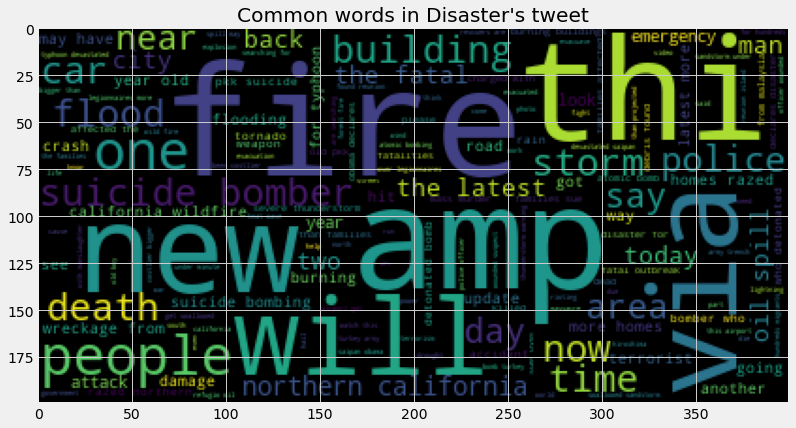

In [161]:
train_corpus= create_corpus(train,1)
plt.figure(figsize=(12,8))
wc= WordCloud().generate(' '.join(train_corpus))
plt.imshow(wc)
plt.title("Common words in Disaster's tweet")
plt.show()

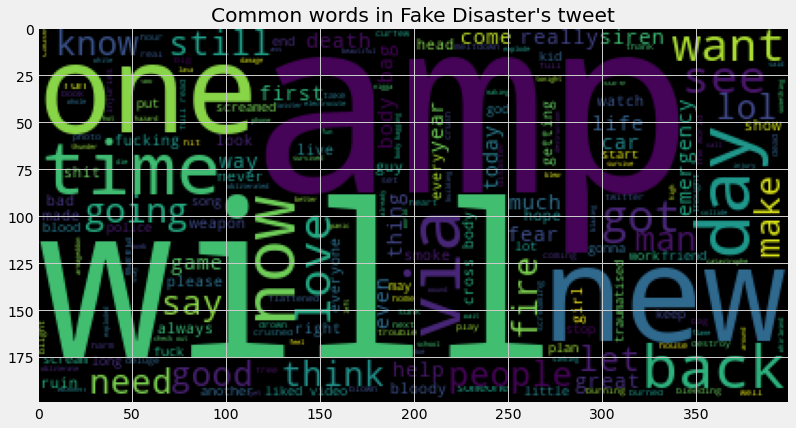

In [162]:
train_corpus= create_corpus(train,0)
plt.figure(figsize=(12,8))
wc= WordCloud().generate(' '.join(train_corpus))
plt.imshow(wc)
plt.title("Common words in Fake Disaster's tweet")
plt.show()

In [163]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [164]:
train=train.drop(['keyword','id','location'],axis=1)
test= test.drop(['keyword','location'],axis=1)

In [165]:
import nltk
from nltk.corpus import stopwords
from spacy.lang.en.stop_words import STOP_WORDS #-- set
s1= stopwords.words('english') #-- list
print(len(STOP_WORDS))

aa=[STOP_WORDS.add(word) for word in s1 if word not in STOP_WORDS]
print(len(STOP_WORDS))


382
382


In [166]:
cv= CountVectorizer(stop_words=STOP_WORDS)
train= pd.DataFrame(cv.fit_transform(train['text']).todense())
test= pd.DataFrame(cv.transform(test['text']).todense())

In [167]:
X= train
y= train_set_orig['target']

In [168]:
print(train.shape)
print(test.shape)

(7613, 12245)
(3263, 12245)


In [169]:
print(X.shape)
print(y.shape)

(7613, 12245)
(7613,)


In [170]:
from sklearn.model_selection import train_test_split
train_x,val_x,test_y,val_y = train_test_split(X,y)
print(train_x.shape)
print(val_x.shape)
print(test_y.shape)
print(val_y.shape)

(5709, 12245)
(1904, 12245)
(5709,)
(1904,)


In [171]:
print(len(val_x))
len(val_y)

1904


1904

In [172]:
import numpy as np

def initialize_parameters(X):
    w= np.zeros(X.shape[1])
    b=0
    return w,b
def sigmoid(z):
    return 1/(1+np.exp(-z))

    
def propogate(w,b,X,y):
    m= len(X)
    z= X.dot(w.T)
    A= sigmoid(z)
    cost=- 1/m * np.sum(y * np.log(A) + (1-y)* np.log(1-A))
    dz= A-y
    dw= np.dot(dz.T , X) * (1/m)
    db= sum(A-y) * (1/m)
    
    grads={'dw':dw,'db':db}
    return cost,grads

def gradient_descent(w,b,X,y,grads,alpha,num_iteration):
    
    for i in range(num_iteration):     
        
        dw= grads['dw']
        db= grads['db']
        
        w= w- alpha * dw
        b= b- alpha * db
        
        cost,grads= propogate(w,b,X,y)
        if i%100 ==0:
            print(f'iterations:{i} --> cost {cost *100}')
            
    return cost,grads

X1=train_x
Y1=test_y

w,b=initialize_parameters(X1)
cost,grads= propogate(w,b,X1,Y1)
best_cost,best_grads= gradient_descent(w,b,X1,Y1,grads,0.9,1000)

# print('w',w.shape)
# print('X',X1.shape)
# print('y',Y1.shape)

iterations:0 --> cost 69.12306122348028
iterations:100 --> cost 57.42415850985908
iterations:200 --> cost 51.837543905630625
iterations:300 --> cost 48.271009243847246
iterations:400 --> cost 45.67666246198947
iterations:500 --> cost 43.64508457894412
iterations:600 --> cost 41.97689912309765
iterations:700 --> cost 40.561299149373326
iterations:800 --> cost 39.33093799992315
iterations:900 --> cost 38.24210275308392


In [188]:
dw1= best_grads['dw']
def predict(X,w):
    y_pred= sigmoid(X.dot(w.T))<0.5
    return y_pred.map({True: 1,False: 0})
y_pred= predict(val_x,dw1)
mean_absolute_error(y_pred,val_y)

0.23319327731092437

In [187]:
#1 real disaster == less than 0.5
#0 unreal disaster 
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_pred,val_y)

0.7668067226890757

In [203]:
answer= predict(test,dw1)
output= pd.DataFrame({'id':test_set_orig['id'],'target':answer})
output.to_csv('submission_correct.csv',index=False)

##  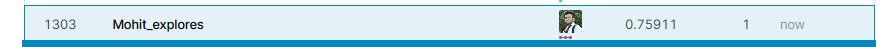